### Final Model Training & Testing

This notebook trains and evaluates the final **Decision Tree model** for classifying mushrooms as **edible or poisonous**.  
It is based on previous **hyperparameter tuning, overfitting analysis, and pruning results**, ensuring optimal generalization.

- The **Depth-15 Decision Tree** was selected because it **balances accuracy and interpretability**.
- It avoids **overfitting**, unlike a fully grown tree, while retaining strong predictive power.
- Final evaluation includes testing on a completely **unseen holdout set** for **true generalization assessment**.

Steps Covered:
- **Train the final decision tree** with the selected hyperparameters.
- **Evaluate accuracy** on the training, test, and holdout datasets.
- **Analyze model performance** using feature importance and confusion matrix.
- **Save the trained model** for reproducibility.



In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from decision_tree import DecisionTree  # Import the custom Decision Tree class
import joblib
import os





In [2]:
if "X_train" not in globals():
    X_train = np.load("X_train.npy")
    y_train = np.load("y_train.npy")
    X_test = np.load("X_test.npy")
    y_test = np.load("y_test.npy")
    print("Datasets loaded successfully!")
    
    # Define model path
model_path = "final_decision_tree.pkl"

Datasets loaded successfully!


#### Train the Final Decision Tree Model
Train the best-performing decision tree using the optimal parameters from hyperparameter tuning.
- The final model is trained with Depth = 15, chosen for its balance between accuracy and complexity.
- Training on the full dataset ensures the model has the most information to learn from.


In [3]:
###Train the Best Model Selected from decision_tree_training.ipynb**
if not os.path.exists(model_path):
    print("\nNo pre-trained model found. Training the final decision tree using best hyperparameters...")
    final_tree = DecisionTree(max_depth=15, min_impurity_decrease=0.01, criterion="gini")
    final_tree.fit(X_train, y_train)
    joblib.dump(final_tree, model_path)
    print("\nFinal Decision Tree trained and saved!")
else:
    print("\nLoading previously trained model for evaluation...")
    final_tree = joblib.load(model_path)


Loading previously trained model for evaluation...


#### Evaluate Final Model
Measure how well the final tree performs on both training and test data.
- If train accuracy is significantly higher than test accuracy, there may still be some overfitting.
- If train and test accuracy are close, the model is generalizing well.

In [10]:
# Compute training and test accuracy
train_accuracy = accuracy_score(y_train, final_tree.predict(X_train))
test_accuracy = accuracy_score(y_test, final_tree.predict(X_test))

# Save accuracy values for reuse in other notebooks
np.save("final_tree_train_accuracy.npy", train_accuracy)
np.save("final_tree_test_accuracy.npy", test_accuracy)

results_df = pd.DataFrame({
    "Metric": ["Training Accuracy", "Test Accuracy"],
    "Accuracy": [train_accuracy, test_accuracy]
})
print("\nFinal Model Performance:")
display(results_df)


Final Model Performance:


,Metric,Accuracy
0,Training Accuracy,0.954007
1,Test Accuracy,0.950055


#### Confusion Matrix for Test Predictions

- A confusion matrix helps analyze misclassifications and whether the model struggles with certain cases.

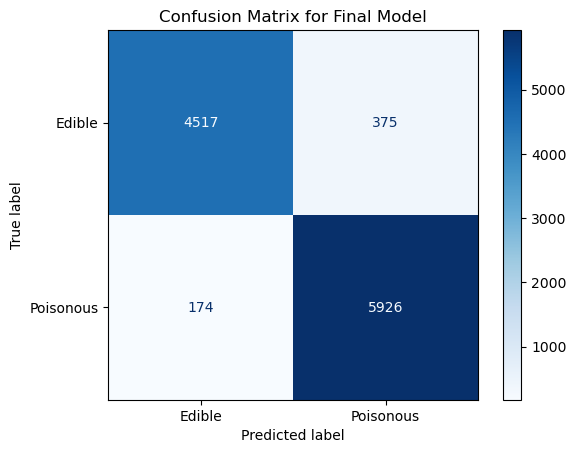

In [5]:
# Compute confusion matrix
cm = confusion_matrix(y_test, final_tree.predict(X_test))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Edible", "Poisonous"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Final Model")
plt.show()


#### Feature Importance Analysis
Identify which features have the greatest impact on classification.

- The most important features should logically align with mushroom classification (e.g., cap shape, color, bruising).
- If some unexpected features have high importance, it may indicate data bias or need for further investigation.

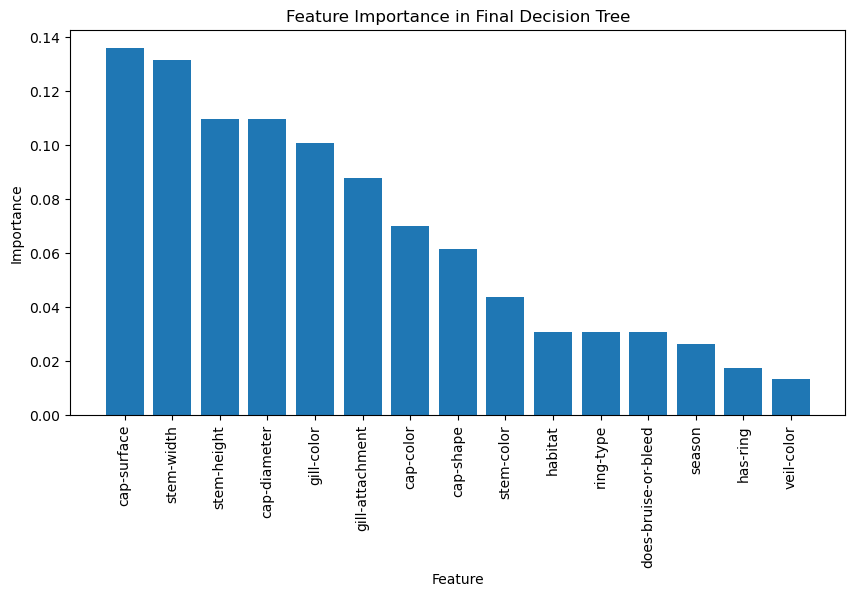

In [6]:
#Load Feature Names & Verify Feature Importance**
feature_names = np.load("feature_names.npy", allow_pickle=True)

# Ensure feature mapping is correct before plotting
if hasattr(final_tree, "feature_importances_") and len(feature_names) == len(final_tree.feature_importances_):
    # Sort features by importance
    sorted_idx = np.argsort(final_tree.feature_importances_)[::-1]

    # Plot feature importance
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(feature_names)), final_tree.feature_importances_[sorted_idx], align="center")
    plt.xticks(range(len(feature_names)), np.array(feature_names)[sorted_idx], rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.title("Feature Importance in Final Decision Tree")
    plt.show()
else:
    print("\nFeature importance is not available or there is a mismatch in feature count.")

#### Verification on Unseen Data
Test the final model on a completely unseen holdout set (10% of the test set).
- If holdout accuracy is close to test accuracy, the model is stable and generalizes well.
- A large drop in holdout accuracy would indicate overfitting to the training and test sets.

In [7]:
#Evaluate on Final Holdout Test Set
X_final_test = np.load("X_final_test.npy")
y_final_test = np.load("y_final_test.npy")

final_test_accuracy = accuracy_score(y_final_test, final_tree.predict(X_final_test))
print(f"\nFinal Model - Holdout Test Accuracy: {final_test_accuracy:.4f}")


Final Model - Holdout Test Accuracy: 0.9452


#### Model Generalization Performance
Compare accuracy across training, test, and final holdout datasets.

- If accuracy remains consistent across all three, the model is robust.
- If holdout accuracy is lower, the model might be overfitting slightly to training and test data.
- If test accuracy is much higher than train accuracy, the model may be underfitting and missing patterns.

Training Accuracy: 0.9540
Test Accuracy: 0.9501
Final Holdout Accuracy: 0.9452


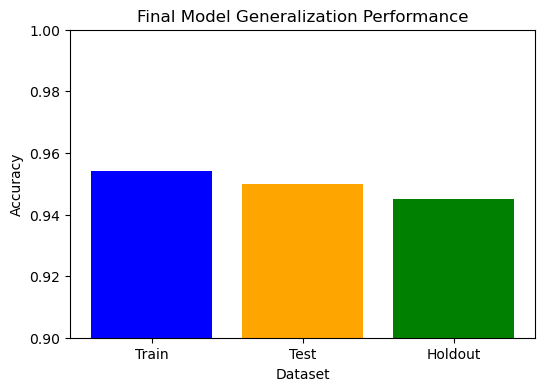

In [8]:
#Visualizing Accuracy Performance**
final_results_df = pd.DataFrame({
    "Metric": ["Training Accuracy", "Test Accuracy", "Final Holdout Accuracy"],
    "Accuracy": [train_accuracy, test_accuracy, final_test_accuracy]
})

# Ensure accuracy values are reasonable (not NaN)
if any(np.isnan([train_accuracy, test_accuracy, final_test_accuracy])):
    raise ValueError("Accuracy contains NaN values. Check model training!")

# Print final accuracy results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Final Holdout Accuracy: {final_test_accuracy:.4f}")

# Plot Accuracy Comparison
plt.figure(figsize=(6, 4))
plt.bar(["Train", "Test", "Holdout"], [train_accuracy, test_accuracy, final_test_accuracy], color=["blue", "orange", "green"])
plt.xlabel("Dataset")
plt.ylabel("Accuracy")
plt.title("Final Model Generalization Performance")
plt.ylim(0.9, 1.0)  # Adjusting for better visibility
plt.show()